# Developing an AI application

Going forward, AI algorithms will be incorporated into more and more everyday applications. For example, you might want to include an image classifier in a smart phone app. To do this, you'd use a deep learning model trained on hundreds of thousands of images as part of the overall application architecture. A large part of software development in the future will be using these types of models as common parts of applications. 

In this project, you'll train an image classifier to recognize different species of flowers. You can imagine using something like this in a phone app that tells you the name of the flower your camera is looking at. In practice you'd train this classifier, then export it for use in your application. We'll be using [this dataset](http://www.robots.ox.ac.uk/~vgg/data/flowers/102/index.html) of 102 flower categories, you can see a few examples below. 

<img src='assets/Flowers.png' width=500px>

The project is broken down into multiple steps:

* Load and preprocess the image dataset
* Train the image classifier on your dataset
* Use the trained classifier to predict image content

We'll lead you through each part which you'll implement in Python.

When you've completed this project, you'll have an application that can be trained on any set of labeled images. Here your network will be learning about flowers and end up as a command line application. But, what you do with your new skills depends on your imagination and effort in building a dataset. For example, imagine an app where you take a picture of a car, it tells you what the make and model is, then looks up information about it. Go build your own dataset and make something new.

First up is importing the packages you'll need. It's good practice to keep all the imports at the beginning of your code. As you work through this notebook and find you need to import a package, make sure to add the import up here.

In [1]:
# Imports here
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import matplotlib.pyplot as plt

import torch
from torch import nn
from torch import optim
import torch.nn.functional as F
from torchvision import datasets, transforms, models
from collections import OrderedDict

import json
import time

from PIL import Image

import math
import numpy as np

## Alex Kirko: Transfer Learning considerations and a sanity check

I have some apprehensions about the suggested approach for some models. By the point where a classifier is used, some networks have already adapted to the data structure and its task. The classifier itself is a single layer for ResNet, SqueezeNet, DenseNet, and Inception, something like `(fc): Linear(in_features=2048, out_features=1000, bias=True)`. This means that these models have features that allow linear separation of ImageNet classes, and all that remains is to train a linear classifier on them. In this lab it's suggested to train a non-linear classifier, but this should work well well only if ImageNet itself has a set of classes similar to one we are trying to classify our images into (see [Stanford Class CS231n](http://cs231n.github.io/transfer-learning/)). Otherwise the features won't have the required information for classification, and no classifier built on top of them will perform as well as updating the weights deeper in the network will.

The models supplied by `torchvision.models` are trained using the 2012 ImageNet challenge dataset (Large Scale Visual Recognition Challenge 2012). The list of classes (called synsets) is available at the [ImageNet website](http://image-net.org/challenges/LSVRC/2012/browse-synsets).

Flowers are symmetrical, colorful, complex objects. When I look at the ImageNet classes, I see that most of the challenge was in separating animals species from each other and classifying man-made objects. VGG and AlexNet have three layers in the classifier, so they'll likely have room to adapt to the differences in domain. Other models should be less flexible.

To test this hypothesis, I will provide support for VGG and Inception V3, and we'll see whether a classifier built on top of Inception will perform worse.

This notebook will be set up to run VGG to satisfy the requirements of the rubric, and the rest of the functionality will be available through initializing `model_name` differently two code cells down.

## Alex Kirko: Set up project settings as variables

Because I will later be using this notebook as the starting point for a console application, it pays to set up everything that the user will be able to supply through command prompt as variables here, at the head of the notebook. Then I will be able to `import argparse` and change very little code for my train.py

In [2]:
net_archs = {
    'AlexNet' : models.alexnet,
    'VGG-11 BN' : models.vgg11_bn,
    'VGG-13 BN' : models.vgg13_bn,
    'VGG-16 BN' : models.vgg16_bn,
    'VGG-19 BN' : models.vgg19_bn,
    'Inception V3' : models.inception_v3
}

net_classes = {
    'VGG-11 BN' : 'VGG',
    'VGG-13 BN' : 'VGG',
    'VGG-16 BN' : 'VGG',
    'VGG-19 BN' : 'VGG',
    'AlexNet' : 'AlexNet',
    'Inception V3' : 'Inception'
}

net_prefixes = {
    'VGG-11 BN' : 'vgg11_bn_',
    'VGG-13 BN' : 'vgg13_bn_',
    'VGG-16 BN' : 'vgg16_bn_',
    'VGG-19 BN' : 'vgg19_bn_',
    'AlexNet' : 'alexnet_',
    'Inception V3' : 'inception_v3_'
}

net_params = {
    'AlexNet' : {
        'learning_rate' : 0.001,
        'features_count' : 9216,
        'classifier_hidden' : 2,
        'batch_size' : 64,
        'classifier_name' : 'classifier',
        'img_resize' : 255,
        'img_crop' : 224
    },
    'Inception' : {
        'learning_rate' : 0.001,
        'features_count' : 2048,
        'classifier_hidden' : 0,
        'batch_size' : 64,
        'classifier_name' : 'fc',
        'img_resize' : 400,
        'img_crop' : 299
    },
    'VGG' : {
        'learning_rate' : 0.001,
        'features_count' : 25088,
        'classifier_hidden' : 2,
        'batch_size' : 64,
        'classifier_name' : 'classifier',
        'img_resize' : 255,
        'img_crop' : 224
    }
}

In [3]:
#Choose device
device = 'cuda'

#Choose the model - this determines everything
model_name = 'Inception V3'
#model_name = 'VGG-13 BN'
#model_name = 'AlexNet'

model_class = net_classes[model_name]
model_load = net_archs[model_name]
net_prefix = net_prefixes[model_name]

features_count = net_params[model_class]['features_count']
learning_rate = net_params[model_class]['learning_rate']
batch_size = net_params[model_class]['batch_size']
classifier_name = net_params[model_class]['classifier_name']
img_resize = net_params[model_class]['img_resize']
img_crop = net_params[model_class]['img_crop']

user_hidden = 2
classifier_hidden = user_hidden

In [4]:
def get_classifier(features_count, classifier_hidden=0, dropout_p=0.5):
    ''' Get a new classifier for the neural network
    
    In:
    features_count : number of inputs to the classifier
    classifier_hidden : number of hidden layers in
                        the classifier
    dropout_p : dropout probability for the hidden layers
    
    Out:
    classifier : new classifier (nn.Sequential)
    '''
    
    
    # Return a classifier based on number of features,
    # number of hidden layers, and dropout probability
    output = ('output', nn.LogSoftmax(dim=1))
    
    classifier_spec = OrderedDict([])
    
    in_count = features_count
    
    #Number of final outputs
    out_final = 102
    
    i = 0
    
    if classifier_hidden > 0:
        #Transform the node count range to log2 scale
        feat_log = math.floor(np.log2(features_count))
        out_fin_log = math.ceil(np.log2(out_final))
        # Linearly interpolate hidden layer counts in log2
        # calculate distance
        dist = ((feat_log - out_fin_log) / (classifier_hidden + 1))
        # Build hidden layer output counts in log2 and 
        # return tonormal scale by taking exp
        hidden_outputs = [int(np.exp2(math.floor(feat_log - i * dist))) for i in range(1, classifier_hidden + 1)]
        
        # Check for duplicates
        if len(hidden_outputs) != len(set(hidden_outputs)):
            raise ValueError(str(classifier_hidden) + ' is too many hidden layers. Try 2 or 3.')
        
        
        for i in range(classifier_hidden):
            indeces = ['fc' + str(i + 1), 'relu' + str(i + 1), 'dropout' + str(i + 1)]
            classifier_spec.update({indeces[0] : nn.Linear(in_count, hidden_outputs[i])})
            classifier_spec.update({indeces[1] : nn.ReLU()})
            classifier_spec.update({indeces[2] : nn.Dropout(p=dropout_p)})
            in_count = hidden_outputs[i]
    
    # Getting final class labels
    if i > 0:
        i += 1
    classifier_spec.update({'fc' + str(i + 1) : nn.Linear(in_count, 102)})
    classifier_spec.update({'output' : nn.LogSoftmax(dim=1)})
            
    classifier = nn.Sequential(classifier_spec)
    
    return classifier

## Load the data

Here you'll use `torchvision` to load the data ([documentation](http://pytorch.org/docs/0.3.0/torchvision/index.html)). The data should be included alongside this notebook, otherwise you can [download it here](https://s3.amazonaws.com/content.udacity-data.com/nd089/flower_data.tar.gz). The dataset is split into three parts, training, validation, and testing. For the training, you'll want to apply transformations such as random scaling, cropping, and flipping. This will help the network generalize leading to better performance. You'll also need to make sure the input data is resized to 224x224 pixels as required by the pre-trained networks.

The validation and testing sets are used to measure the model's performance on data it hasn't seen yet. For this you don't want any scaling or rotation transformations, but you'll need to resize then crop the images to the appropriate size.

The pre-trained networks you'll use were trained on the ImageNet dataset where each color channel was normalized separately. For all three sets you'll need to normalize the means and standard deviations of the images to what the network expects. For the means, it's `[0.485, 0.456, 0.406]` and for the standard deviations `[0.229, 0.224, 0.225]`, calculated from the ImageNet images.  These values will shift each color channel to be centered at 0 and range from -1 to 1.
 

In [ ]:
#For local training, use the data on an M.2 SSD

data_dir = 'C:/udacity/data/flowers'
#data_dir = 'data/flowers'
train_dir = data_dir + '/train'
valid_dir = data_dir + '/valid'
test_dir = data_dir + '/test'

In [ ]:
# TODO: Define your transforms for the training, validation, and testing sets
# Alex Kirko: using the transforms suggested in Part 8 of the PyTorch lesson
# since flowers are symmetrical, it won't hurt to rotate them more
# since we'll be using an ImageNet pre-trained network, it's important to
# normalize the color channels the same way they were normalized when these
# models were trained
train_transforms = transforms.Compose([transforms.RandomRotation(45),
                                       transforms.RandomResizedCrop(img_crop),
                                       transforms.RandomHorizontalFlip(),
                                       transforms.ToTensor(),
                                       transforms.Normalize([0.485, 0.456, 0.406],
                                                            [0.229, 0.224, 0.225])])

#Alex Kirko: for validation and test there is no need to introduce randomness to the data
valid_transforms = test_transforms = transforms.Compose([transforms.Resize(img_resize),
                                      transforms.CenterCrop(img_crop),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.485, 0.456, 0.406],
                                                           [0.229, 0.224, 0.225])])


# TODO: Load the datasets with ImageFolder
train_data = datasets.ImageFolder(data_dir + '/train', transform=train_transforms)
valid_data = datasets.ImageFolder(data_dir + '/valid', transform=valid_transforms)
test_data = datasets.ImageFolder(data_dir + '/test', transform=test_transforms)

# TODO: Using the image datasets and the trainforms, define the dataloaders
#Alex Kirko: only the training set benefits from shuffling at the end of each epoch
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True)
valid_loader = torch.utils.data.DataLoader(valid_data, batch_size=batch_size)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size)

### Label mapping

You'll also need to load in a mapping from category label to category name. You can find this in the file `cat_to_name.json`. It's a JSON object which you can read in with the [`json` module](https://docs.python.org/2/library/json.html). This will give you a dictionary mapping the integer encoded categories to the actual names of the flowers.

In [14]:
with open('cat_to_name.json', 'r') as f:
    cat_to_name = json.load(f)
    
#cat_to_name

# Building and training the classifier

Now that the data is ready, it's time to build and train the classifier. As usual, you should use one of the pretrained models from `torchvision.models` to get the image features. Build and train a new feed-forward classifier using those features.

We're going to leave this part up to you. If you want to talk through it with someone, chat with your fellow students! You can also ask questions on the forums or join the instructors in office hours.

Refer to [the rubric](https://review.udacity.com/#!/rubrics/1663/view) for guidance on successfully completing this section. Things you'll need to do:

* Load a [pre-trained network](http://pytorch.org/docs/master/torchvision/models.html) (If you need a starting point, the VGG networks work great and are straightforward to use)
* Define a new, untrained feed-forward network as a classifier, using ReLU activations and dropout
* Train the classifier layers using backpropagation using the pre-trained network to get the features
* Track the loss and accuracy on the validation set to determine the best hyperparameters

We've left a cell open for you below, but use as many as you need. Our advice is to break the problem up into smaller parts you can run separately. Check that each part is doing what you expect, then move on to the next. You'll likely find that as you work through each part, you'll need to go back and modify your previous code. This is totally normal!

When training make sure you're updating only the weights of the feed-forward network. You should be able to get the validation accuracy above 70% if you build everything right. Make sure to try different hyperparameters (learning rate, units in the classifier, epochs, etc) to find the best model. Save those hyperparameters to use as default values in the next part of the project.

In [ ]:
# TODO: Build and train your network
model = model_load(pretrained=True)
model

In [ ]:
# Remove gradient tracking from the network parameters
for param in model.parameters():
    param.requires_grad = False

# Create a new classifier
# Use dropout probability that the VGG models use - 
# authors likely knew what they were doing

classifier = get_classifier(features_count, classifier_hidden=classifier_hidden, dropout_p=0.5)

#Attach the new classifier (it has random weights now)
if classifier_name == 'classifier':
    model.classifier = classifier
elif classifier_name == 'fc':
    model.fc = classifier

In [ ]:
model

In [ ]:
#Check dataset sizes
print(len(train_loader))
print(len(valid_loader))
print(len(test_loader))

In [ ]:
# Move the model to GPU before constructing the optimizer
model.to(device)

# Set up negative likelihood loss and the adam optimizer
# (momentum is useful)
criterion = nn.NLLLoss()
if classifier_name == 'classifier':
    optimizer = optim.Adam(model.classifier.parameters(), lr=learning_rate)
elif classifier_name == 'fc':
    optimizer = optim.Adam(model.fc.parameters(), lr=learning_rate)

# This will take some time, but we need to see how far we can reduce the error
epochs = 15


train_losses, test_losses = [], []
for e in range(epochs):
    start = time.time()
    running_loss = 0
    train_r_acc = 0
    for images, labels in train_loader:
        
        images, labels = images.to(device), labels.to(device)
                
        optimizer.zero_grad()
        
        log_ps = model.forward(images)
        
        #Inception calculates two losses: auxillary and main
        if model_name != 'Inception V3':
            loss = criterion(log_ps, labels)
        else:
            loss = criterion(log_ps[0], labels) + criterion(log_ps[1], labels)
        loss.backward()
        optimizer.step()
        
        #print('Current time: {:.1f}'.format(time.time() - start))
        
        running_loss += loss.item()
        #print('Batch training time: {:.1f}'.format(time.time() - start))
        
        #For debugging. Testing accuracy
        if model_name != 'Inception V3':
            top_log_p, predictions = log_ps.topk(1, dim = 1)
        else:
            top_log_p, predictions = log_ps[0].topk(1, dim = 1)
            #print(predictions)
        equals = predictions == labels.view(*predictions.shape)
        train_r_acc += torch.mean(equals.type(torch.FloatTensor)).item()
        
    else:
        with torch.no_grad():
            ## TODO: Implement the validation pass and print out the validation accuracy
            
            model.eval()
            
            running_acc = 0
            test_loss = 0
            for images, labels in valid_loader:
                
                images, labels = images.to(device), labels.to(device)
                
                log_ps = model.forward(images)
                top_log_p, predictions = log_ps.topk(1, dim = 1)
                equals = predictions == labels.view(*predictions.shape)
                running_acc += torch.mean(equals.type(torch.FloatTensor)).item()
                test_loss += criterion(log_ps, labels)
            train_loss = running_loss / len(train_loader)
            test_loss = test_loss / len(valid_loader)
            accuracy = running_acc / len(valid_loader)
            t_accuracy = train_r_acc / len(train_loader)
            
            train_losses.append(train_loss)
            test_losses.append(test_loss)
            
            model.train()
            
            print('Epoch: {}/{}'.format(e+1, epochs))
            print('Training loss: {0:.2f}'.format(train_loss))
            print('Validation loss: {0:.2f}'.format(test_loss))
            print('Validation Accuracy: {0:.2f}'.format(accuracy*100))
            print('Training accuracy: {0:.2f}'.format(t_accuracy*100))
            print('Epoch training time: {:.1f}'.format(time.time() - start))

## Testing your network

It's good practice to test your trained network on test data, images the network has never seen either in training or validation. This will give you a good estimate for the model's performance on completely new images. Run the test images through the network and measure the accuracy, the same way you did validation. You should be able to reach around 70% accuracy on the test set if the model has been trained well.

In [ ]:
# TODO: Do validation on the test set
model.to(device)

with torch.no_grad():
    model.eval()

    running_acc = 0
    test_loss = 0
    for images, labels in test_loader:

        images, labels = images.to(device), labels.to(device)

        log_ps = model.forward(images)
        top_log_p, predictions = log_ps.topk(1, dim = 1)
        equals = predictions == labels.view(*predictions.shape)
        running_acc += torch.mean(equals.type(torch.FloatTensor)).item()
        test_loss += criterion(log_ps, labels)
    test_loss = test_loss / len(test_loader)
    accuracy = running_acc / len(test_loader)

    model.train()

    print('Epoch: {}/{}'.format(e+1, epochs))
    print('Test loss: {0:.2f}'.format(test_loss))
    print('Accuracy: {0:.2f}'.format(accuracy*100))

Below is testing output for Inception V3, proving that using models with linear classifiers in this manner isn't very effective, even if we replace the linear classifier with a non-linear one (VGG-13 with a replaced classifier easily reaches 90% testing set accuracy).

This supports the intuition I wrote about at the head of this project: because ImageNet doesn't have many flower-like classes, we should be retraining more than one layer.

`Epoch: 15/15
Test loss: 1.10
Accuracy: 73.28`

## Save the checkpoint

Now that your network is trained, save the model so you can load it later for making predictions. You probably want to save other things such as the mapping of classes to indices which you get from one of the image datasets: `image_datasets['train'].class_to_idx`. You can attach this to the model as an attribute which makes inference easier later on.

```model.class_to_idx = image_datasets['train'].class_to_idx```

Remember that you'll want to completely rebuild the model later so you can use it for inference. Make sure to include any information you need in the checkpoint. If you want to load the model and keep training, you'll want to save the number of epochs as well as the optimizer state, `optimizer.state_dict`. You'll likely want to use this trained model in the next part of the project, so best to save it now.

In [ ]:
# TODO: Save the checkpoint 

class_to_idx = train_data.class_to_idx
optim_state_dict = optimizer.state_dict()

#print("Our model: \n\n", model, '\n')
#print("The state dict keys: \n\n", model.state_dict().keys())

#Based on https://pytorch.org/tutorials/beginner/saving_loading_models.html
checkpoint = {
    'epoch': e,
    'optim_state_dict': optim_state_dict,
    'model_name': model_name,
    'optim_class' : 'Adam',
    'loss_class' : 'NLLLoss',
    'model_device' : device,
    'model_state_dict': model.state_dict(),
    'class_to_idx' : class_to_idx,
    'learning_rate' : learning_rate,
    'classifier_hidden' : classifier_hidden
}

save_filename = None
if save_filename:
    torch.save(checkpoint, save_filename)
else:
    torch.save(checkpoint, net_prefix + 'checkpoint.pth')

## Loading the checkpoint

At this point it's good to write a function that can load a checkpoint and rebuild the model. That way you can come back to this project and keep working on it without having to retrain the network.

In [5]:
# TODO: Write a function that loads a checkpoint and rebuilds the model

def model_load(path):
    ''' Load a model from checkpoint
    
    In:
    path : path to the checkpoint file
    
    Out:
    model : model object
    criterion : loss function
    optimizer : initialized optimizer
    epoch : epoch at which the model finished training
    device : device from which the model was saved
    model_name : model name 
                 (used to get settings for the model)
    '''
    checkpoint = torch.load(path)
    
    model_name = checkpoint['model_name']
    loss_class = checkpoint['loss_class']
    optim_class = checkpoint['optim_class']
    model_device = checkpoint['model_device']
    class_to_idx = checkpoint['class_to_idx']
    learning_rate = checkpoint['learning_rate']
    classifier_hidden = checkpoint['classifier_hidden']
    
    model_class = net_classes[model_name]
    model_load = net_archs[model_name]
    net_prefix = net_prefixes[model_name]
    
    #Initialize parameters needed to build the network
    features_count = net_params[model_class]['features_count']
    batch_size = net_params[model_class]['batch_size']
    classifier_name = net_params[model_class]['classifier_name']
    img_resize = net_params[model_class]['img_resize']
    img_crop = net_params[model_class]['img_crop']
        
    model = model_load(pretrained=False)
    
    for param in model.parameters():
        param.requires_grad = False

    # Create a new classifier
    classifier = get_classifier(features_count, classifier_hidden=classifier_hidden, dropout_p=0.5)
    #Attach the new classifier (it has random weights now)
    if classifier_name == 'classifier':
        model.classifier = classifier
    elif classifier_name == 'fc':
        model.fc = classifier
        
    model.to(model_device)
    model.load_state_dict(checkpoint['model_state_dict'])
    model.class_to_idx = class_to_idx
    # What we need to get human-readable labels
    # is a mapping from indices to class labels
    model.idx_to_class = {idx : c for c, idx in model.class_to_idx.items()}
    
    
    if loss_class == 'NLLLoss':
        criterion = nn.NLLLoss()        
    else:
        raise ValueError(loss_class + ' loss function is not supported. Your model should use NLLLoss.')
    
    if optim_class == 'Adam':
        if classifier_name == 'classifier':
            optimizer = optim.Adam(model.classifier.parameters(), lr=learning_rate)
        elif classifier_name == 'fc':
            optimizer = optim.Adam(model.fc.parameters(), lr=learning_rate)
    else:
        raise ValueError(optim_class + ' optimizer is not supported. Your model should use Adam.')
    
    #optimizer.load_state_dict(checkpoint['optim_state_dict'])
    epoch = checkpoint['epoch']
    
    device = model_device
    
    return model, criterion, optimizer, epoch, device, model_name

In [47]:
net_prefix = 'vgg13_bn_'
model, criterion, optimizer, epoch, device, model_name = model_load(net_prefix + 'checkpoint.pth')

# Inference for classification

Now you'll write a function to use a trained network for inference. That is, you'll pass an image into the network and predict the class of the flower in the image. Write a function called `predict` that takes an image and a model, then returns the top $K$ most likely classes along with the probabilities. It should look like 

```python
probs, classes = predict(image_path, model)
print(probs)
print(classes)
> [ 0.01558163  0.01541934  0.01452626  0.01443549  0.01407339]
> ['70', '3', '45', '62', '55']
```

First you'll need to handle processing the input image such that it can be used in your network. 

## Image Preprocessing

You'll want to use `PIL` to load the image ([documentation](https://pillow.readthedocs.io/en/latest/reference/Image.html)). It's best to write a function that preprocesses the image so it can be used as input for the model. This function should process the images in the same manner used for training. 

First, resize the images where the shortest side is 256 pixels, keeping the aspect ratio. This can be done with the [`thumbnail`](http://pillow.readthedocs.io/en/3.1.x/reference/Image.html#PIL.Image.Image.thumbnail) or [`resize`](http://pillow.readthedocs.io/en/3.1.x/reference/Image.html#PIL.Image.Image.thumbnail) methods. Then you'll need to crop out the center 224x224 portion of the image.

Color channels of images are typically encoded as integers 0-255, but the model expected floats 0-1. You'll need to convert the values. It's easiest with a Numpy array, which you can get from a PIL image like so `np_image = np.array(pil_image)`.

As before, the network expects the images to be normalized in a specific way. For the means, it's `[0.485, 0.456, 0.406]` and for the standard deviations `[0.229, 0.224, 0.225]`. You'll want to subtract the means from each color channel, then divide by the standard deviation. 

And finally, PyTorch expects the color channel to be the first dimension but it's the third dimension in the PIL image and Numpy array. You can reorder dimensions using [`ndarray.transpose`](https://docs.scipy.org/doc/numpy-1.13.0/reference/generated/numpy.ndarray.transpose.html). The color channel needs to be first and retain the order of the other two dimensions.

In [48]:
# Note: we could have just used test_loader

# TODO: Process a PIL image for use in a PyTorch model
def process_image(img, model_name, net_classes, net_params):
    ''' Scales, crops, and normalizes a PIL image for a PyTorch model,
        returns a torch.Tensor
        
        In:
        img : a PIL image created with Image.open
        model_name : model_name (used to get settings)
        net_classes : mapping of model names to classes
        net_params : mapping of model classes to
                     their default parameters
        
        Out:
        img : tensor ready for the model
    '''
    
    model_class = net_classes[model_name]
    img_resize = net_params[model_class]['img_resize']
    img_crop = net_params[model_class]['img_crop']
    
    width, height = img.size
    if width < height:
        size = (img_resize, math.floor(height * img_resize / width))
    else:
        size = (math.floor(width * img_resize / height), img_resize)
    
    img = img.resize(size)
                
    width, height = size
    # Crop based on this stackoverflow article
    # https://stackoverflow.com/questions/16646183/crop-an-image-in-the-centre-using-pil
    
    left = (width - img_crop)/2
    top = (height - img_crop)/2
    right = (width + img_crop)/2
    bottom = (height + img_crop)/2

    img = img.crop((left, top, right, bottom))
    
    img = np.array(img)
    
    img = img / 255
    
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    img = (img - mean) / std
    
    img = img.transpose(2, 0, 1)
    img = torch.tensor(img)
    
    # Sometimes the tensor gets cast to DoubleTensor.
    # This can break a model.
    img = img.type(torch.FloatTensor)
    
    return img
    
    

To check your work, the function below converts a PyTorch tensor and displays it in the notebook. If your `process_image` function works, running the output through this function should return the original image (except for the cropped out portions).

In [49]:
def imshow(image, net_classes, net_params, ax=None, title=None):
    ''' Imshow for Tensor
    
    In:
    image : image tensor
    ax : existing axis on which to draw the image
    title : image title (reserved argument)
    
    Out:
    ax : axis with image drawn on it
    '''
    if ax is None:
        fig, ax = plt.subplots()
    
    # PyTorch tensors assume the color channel is the first dimension
    # but matplotlib assumes is the third dimension
    # Alex Kirko: The image is already a np_array
    image = image.numpy().transpose((1, 2, 0))
    
    # Undo preprocessing
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    image = std * image + mean
    
    # Image needs to be clipped between 0 and 1 or it looks like noise when displayed
    image = np.clip(image, 0, 1)
    
    ax.imshow(image)
    
    return ax

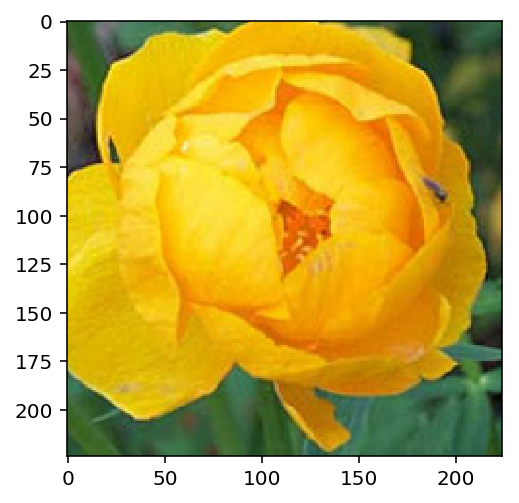

In [51]:

img = Image.open('data/flowers/test/16/image_06657.jpg')

img = process_image(img, model_name, net_classes, net_params)

ax = imshow(img)

## Class Prediction

Once you can get images in the correct format, it's time to write a function for making predictions with your model. A common practice is to predict the top 5 or so (usually called top-$K$) most probable classes. You'll want to calculate the class probabilities then find the $K$ largest values.

To get the top $K$ largest values in a tensor use [`x.topk(k)`](http://pytorch.org/docs/master/torch.html#torch.topk). This method returns both the highest `k` probabilities and the indices of those probabilities corresponding to the classes. You need to convert from these indices to the actual class labels using `class_to_idx` which hopefully you added to the model or from an `ImageFolder` you used to load the data ([see here](#Save-the-checkpoint)). Make sure to invert the dictionary so you get a mapping from index to class as well.

Again, this method should take a path to an image and a model checkpoint, then return the probabilities and classes.

```python
probs, classes = predict(image_path, model)
print(probs)
print(classes)
> [ 0.01558163  0.01541934  0.01452626  0.01443549  0.01407339]
> ['70', '3', '45', '62', '55']
```

In [52]:
#Make sure class_to_idx is recoverable from checkpoint
def predict(image_path, model, model_name, 
            net_classes, net_params, topk=5, device='cpu'):
    ''' Predict the class (or classes) of an image using a trained deep learning model
    based on filepath.
    
    In:
    image_path : path to the image file
    model : model used to predict the classes    
    model_name : model_name (used to get settings)
    net_classes : mapping of model names to classes
    net_params : mapping of model classes to
                 their default parameters
    topk : number of top classes to get
    device : device on which to predict
    '''
    model_class = net_classes[model_name]
    img_crop = net_params[model_class]['img_crop']
    
    img = Image.open(image_path)

    img = process_image(img, model_name, net_classes, net_params)
    img.resize_(1, 3, img_crop, img_crop)
    
    model.to(device)
    img = img.to(device)
    model.eval()
    # Calculate the class probabilities (softmax) for img
    with torch.no_grad():
        output = model.forward(img)
    
    
    model.train()
    
    ps = torch.exp(output)
    top_p, predictions = ps.topk(topk, dim = 1)
    idxs = [model.idx_to_class[x.item()] for x in predictions[0]]
    #print(idxs)
    return top_p.cpu(), idxs
    
    # TODO: Implement the code to predict the class from an image file

In [53]:
def predict_preprocessed(img, model, model_name, 
                         net_classes, net_params, topk=5, device='cpu'):

    ''' Predict the class (or classes) of an image using a trained deep learning model
    based on an image tensor.
    
    In:
    img : image tensor
    model : model used to predict the classes    
    model_name : model_name (used to get settings)
    net_classes : mapping of model names to classes
    net_params : mapping of model classes to
                 their default parameters
    topk : number of top classes to get
    device : device on which to predict
    '''
    model_class = net_classes[model_name]
    img_crop = net_params[model_class]['img_crop']
    
    img.resize_(1, 3, img_crop, img_crop)
    
    model.to(device)
    img = img.to(device)
    model.eval()
    # Calculate the class probabilities (softmax) for img
    with torch.no_grad():
        output = model.forward(img)
    
    model.train()
    
    print(output.shape)
    
    ps = torch.exp(output)
    top_p, predictions = ps.topk(topk, dim = 1)
    idxs = [model.idx_to_class[x.item()] for x in predictions[0]]
    #print(idxs)
    return top_p.cpu(), idxs
    
    # TODO: Implement the code to predict the class from an image file

## Sanity Checking

Now that you can use a trained model for predictions, check to make sure it makes sense. Even if the testing accuracy is high, it's always good to check that there aren't obvious bugs. Use `matplotlib` to plot the probabilities for the top 5 classes as a bar graph, along with the input image. It should look like this:

<img src='assets/inference_example.png' width=300px>

You can convert from the class integer encoding to actual flower names with the `cat_to_name.json` file (should have been loaded earlier in the notebook). To show a PyTorch tensor as an image, use the `imshow` function defined above.

['water lily', 'lotus lotus', 'oxeye daisy', 'spring crocus', 'siam tulip']


<Figure size 432x288 with 0 Axes>

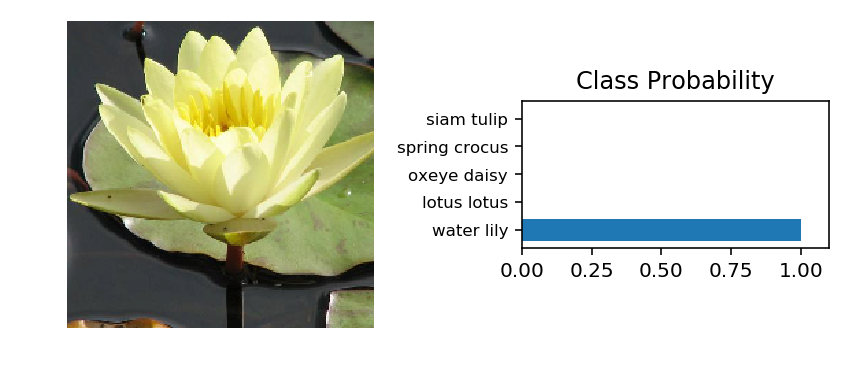

In [55]:
# TODO: Display an image along with the top 5 classes
img = Image.open('data/flowers/test/73/image_00394.jpg')

img = process_image(img, model_name, net_classes, net_params)

top_p, idxs = predict('data/flowers/test/73/image_00394.jpg', model, model_name, 
                      net_classes, net_params, device='cuda')
cat_names = [cat_to_name[x] for x in idxs]
top_p = top_p.numpy().squeeze()

print(cat_names)

#denormalize
img = img.numpy().transpose((1, 2, 0))

mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])
img = std * img + mean
img = np.clip(img, 0, 1)
img = img.astype(np.float64)

#print(img.shape)
#print((np.min(img), np.max(img)))

plt.clf()
fig, (ax1, ax2) = plt.subplots(figsize=(6,9), ncols=2)
ax1.imshow(img)
ax1.axis('off')
ax2.barh(np.arange(5), top_p)
ax2.set_aspect(0.1)
ax2.set_yticks(np.arange(5))
ax2.set_yticklabels(cat_names, size='small');
ax2.set_title('Class Probability')
ax2.set_xlim(0, 1.1)

plt.tight_layout()

In [56]:
#Loader for random test flower

model_class = net_classes[model_name]
img_resize = net_params[model_class]['img_resize']
img_crop = net_params[model_class]['img_crop']
batch_size = net_params[model_class]['batch_size']


data_dir = 'C:/udacity/data/flowers'
#data_dir = 'data/flowers'

test_dir = data_dir + '/test'


test_transforms = transforms.Compose([transforms.Resize(img_resize),
                                      transforms.CenterCrop(img_crop),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.485, 0.456, 0.406],
                                                           [0.229, 0.224, 0.225])])


test_data = datasets.ImageFolder(data_dir + '/test', transform=test_transforms)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size)

In [57]:
testiter = iter(test_loader)

torch.Size([64, 3, 224, 224])
torch.Size([1, 102])


<Figure size 432x288 with 0 Axes>

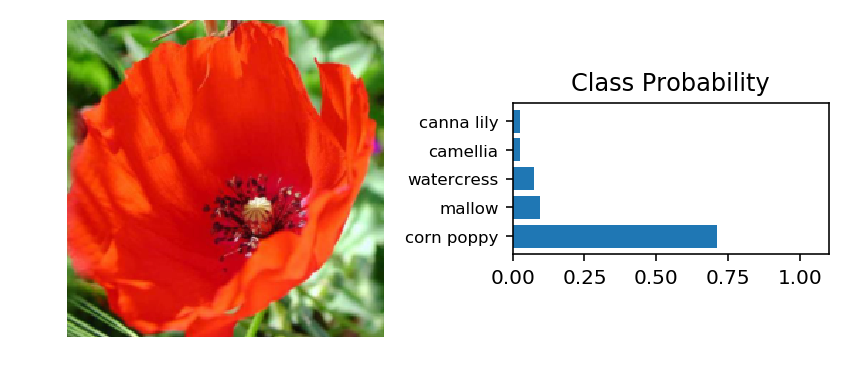

In [59]:
#Now for random flower

model_class = net_classes[model_name]
img_crop = net_params[model_class]['img_crop']

try:
    images, labels = testiter.next()
except:
    testiter = iter(test_loader)
    images, labels = testiter.next()
    
print(images.shape)
img = images[np.random.randint(64)]
img.resize_(1,3,img_crop,img_crop)

# Calculate the class probabilities (softmax) for img
top_p, idxs = predict_preprocessed(img, model, model_name, 
                                   net_classes, net_params, topk=5, device='cuda')
cat_names = [cat_to_name[x] for x in idxs]
top_p = top_p.numpy().squeeze()

#print(ps)sp

#img could have been moved to cuda
#img = img.to('cpu')

#denormalize
img = img[0].numpy().transpose((1, 2, 0))

mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])
img = std * img + mean
img = np.clip(img, 0, 1)
img = img.astype(np.float64)

#print(img.shape)
#print((np.min(img), np.max(img)))

plt.clf()
fig, (ax1, ax2) = plt.subplots(figsize=(6,9), ncols=2)
ax1.imshow(img)
ax1.axis('off')
ax2.barh(np.arange(5), top_p)
ax2.set_aspect(0.1)
ax2.set_yticks(np.arange(5))
ax2.set_yticklabels(cat_names, size='small');
ax2.set_title('Class Probability')
ax2.set_xlim(0, 1.1)

plt.tight_layout()